In [ ]:
!git clone https://github.com/Anto357/speech-emotiondetection.git

fatal: destination path 'speech-emotiondetection' already exists and is not an empty directory.


### Feature Extraction

In [ ]:
import os
import numpy as np
import torch
import librosa
from tqdm import tqdm
import logging
import pandas as pd

# Suppress transformers logging to avoid Wav2Vec2 warning
logging.getLogger("transformers").setLevel(logging.ERROR)

# Set Device and Paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "/content/speech-emotiondetection/crema/"

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define label mapping
label_map = {
    "SAD": 0,  # sadness
    "ANG": 1,  # angry
    "DIS": 2,  # disgust
    "FEA": 3,  # fear
    "HAP": 4,  # happy
    "NEU": 5   # neutral
}

# Function to extract labels from filenames
def extract_labels_from_filenames(folder_path):
    file_list = []
    label_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            label_str = filename.split("_")[2]
            if label_str in label_map:
                file_list.append(file_path)
                label_list.append(label_map[label_str])

    return file_list, label_list


file_list, label_list = extract_labels_from_filenames(dataset_path)
tqdm.write(f"Found {len(file_list)} audio files.")
tqdm.write(f"Labels found: {set(label_list)}")

Using device: cuda
Found 7442 audio files.
Labels found: {0, 1, 2, 3, 4, 5}


In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# FEATURE EXTRACTION FUNCTIONS
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr=22050, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

# Calculate expected feature length
def get_expected_feature_length(duration=2.5, sr=22050, frame_length=2048, hop_length=512):
    # Number of frames for 2.5 seconds of audio
    num_samples = int(duration * sr)
    num_frames = 1 + (num_samples - frame_length) // hop_length
    # ZCR and RMSE: 1 value per frame
    zcr_len = num_frames
    rmse_len = num_frames
    # MFCC: 20 coefficients per frame (default in librosa), flattened
    mfcc_len = num_frames * 20
    total_len = zcr_len + rmse_len + mfcc_len
    return total_len

# Expected feature length for 2.5 seconds at 22050 Hz
EXPECTED_FEATURE_LENGTH = get_expected_feature_length()
print(f"Expected feature length: {EXPECTED_FEATURE_LENGTH}")

Expected feature length: 2288


In [ ]:
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    # Extract features
    zcr_data = zcr(data, frame_length, hop_length)
    rmse_data = rmse(data, frame_length, hop_length)
    mfcc_data = mfcc(data, sr, frame_length, hop_length)

    # Pad or truncate to ensure consistent length
    num_frames = 1 + (len(data) - frame_length) // hop_length
    expected_frames = 1 + (int(2.5 * sr) - frame_length) // hop_length

    # Pad or truncate ZCR
    if len(zcr_data) < expected_frames:
        zcr_data = np.pad(zcr_data, (0, expected_frames - len(zcr_data)), mode='constant')
    elif len(zcr_data) > expected_frames:
        zcr_data = zcr_data[:expected_frames]

    # Pad or truncate RMSE
    if len(rmse_data) < expected_frames:
        rmse_data = np.pad(rmse_data, (0, expected_frames - len(rmse_data)), mode='constant')
    elif len(rmse_data) > expected_frames:
        rmse_data = rmse_data[:expected_frames]

    # Pad or truncate MFCC (20 coefficients per frame)
    expected_mfcc_len = expected_frames * 20
    if len(mfcc_data) < expected_mfcc_len:
        mfcc_data = np.pad(mfcc_data, (0, expected_mfcc_len - len(mfcc_data)), mode='constant')
    elif len(mfcc_data) > expected_mfcc_len:
        mfcc_data = mfcc_data[:expected_mfcc_len]

    # Combine features
    result = np.hstack((zcr_data, rmse_data, mfcc_data))
    if len(result) != EXPECTED_FEATURE_LENGTH:
        raise ValueError(f"Feature length {len(result)} does not match expected length {EXPECTED_FEATURE_LENGTH}")
    return result

def get_features(path, duration=2.5, offset=0.6):
    try:
        # Load audio with fixed duration
        data, sr = librosa.load(path, duration=duration, offset=offset, sr=22050)
        # Ensure audio is exactly 2.5 seconds by padding or trimming
        expected_samples = int(duration * sr)
        if len(data) < expected_samples:
            data = np.pad(data, (0, expected_samples - len(data)), mode='constant')
        elif len(data) > expected_samples:
            data = data[:expected_samples]
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return np.zeros((4, EXPECTED_FEATURE_LENGTH))  # Return zero array if loading fails

    audio_features = []
    # Original
    audio_features.append(extract_features(data, sr=sr))
    # Noised
    noised_audio = noise(data.copy())
    audio_features.append(extract_features(noised_audio, sr=sr))
    # Pitched
    pitched_audio = pitch(data.copy(), sr)
    audio_features.append(extract_features(pitched_audio, sr=sr))
    # Pitched + Noised
    pitched_noised_audio = noise(pitch(data.copy(), sr))
    audio_features.append(extract_features(pitched_noised_audio, sr=sr))

    features = np.vstack(audio_features)
    if features.shape != (4, EXPECTED_FEATURE_LENGTH):
        print(f"Unexpected shape for {path}: {features.shape}")
        return np.zeros((4, EXPECTED_FEATURE_LENGTH))
    return features

import timeit

start = timeit.default_timer()
X, Y = [], []

# Iterate over extracted file paths and labels
for index, (path, emotion) in tqdm(enumerate(zip(file_list, label_list)), total=len(file_list)):
    features = get_features(path)
    if features.shape != (4, EXPECTED_FEATURE_LENGTH):
        print(f"Skipping {path} due to incorrect feature shape: {features.shape}")
        continue

    X.extend(features)
    Y.extend([emotion] * len(features))  # Should be 4 labels per file

    if index % 500 == 0:
        print(f'{index} audio files have been processed')

# Verify lengths before creating DataFrame
print(f"Length of X: {len(X)}, Length of Y: {len(Y)}")
if len(X) != len(Y):
    raise ValueError("Mismatch between X and Y lengths")

# Convert to numpy array for consistency
X = np.array(X)
print(f"X shape: {X.shape}")

# Create DataFrame
df = pd.DataFrame(X)
df['Emotions'] = Y
print(f"DataFrame shape: {df.shape}")
print(df.head())

# Save to CSV
df.to_csv('audio_features.csv', index=False)

stop = timeit.default_timer()
print('Time: ', stop - start)

  0%|          | 3/7442 [00:01<55:38,  2.23it/s]  

0 audio files have been processed


  7%|▋         | 502/7442 [00:53<10:34, 10.94it/s]

500 audio files have been processed


 13%|█▎        | 1003/7442 [01:51<09:42, 11.06it/s]

1000 audio files have been processed


 20%|██        | 1502/7442 [02:43<09:26, 10.48it/s]

1500 audio files have been processed


 27%|██▋       | 2003/7442 [03:36<08:41, 10.44it/s]

2000 audio files have been processed


 34%|███▎      | 2503/7442 [04:28<07:40, 10.72it/s]

2500 audio files have been processed


 40%|████      | 3003/7442 [05:19<06:37, 11.18it/s]

3000 audio files have been processed


 47%|████▋     | 3502/7442 [06:10<05:41, 11.53it/s]

3500 audio files have been processed


 54%|█████▍    | 4003/7442 [07:02<05:12, 11.02it/s]

4000 audio files have been processed


 61%|██████    | 4503/7442 [07:54<04:27, 11.00it/s]

4500 audio files have been processed


 67%|██████▋   | 5003/7442 [08:45<03:45, 10.79it/s]

5000 audio files have been processed


 74%|███████▍  | 5503/7442 [09:38<02:56, 11.01it/s]

5500 audio files have been processed


 81%|████████  | 6003/7442 [10:31<02:15, 10.65it/s]

6000 audio files have been processed


 87%|████████▋ | 6503/7442 [11:25<01:27, 10.71it/s]

6500 audio files have been processed


 94%|█████████▍| 7002/7442 [12:18<00:41, 10.61it/s]

7000 audio files have been processed


100%|██████████| 7442/7442 [13:06<00:00,  9.46it/s]


Length of X: 29768, Length of Y: 29768
X shape: (29768, 2288)
DataFrame shape: (29768, 2289)
          0         1         2         3         4         5         6  \
0  0.021973  0.030762  0.041504  0.043457  0.041504  0.041504  0.035645   
1  0.087891  0.107422  0.123047  0.116211  0.104004  0.122559  0.130371   
2  0.020996  0.033203  0.048340  0.046875  0.049805  0.042480  0.033203   
3  0.020996  0.033203  0.048340  0.046875  0.050781  0.043457  0.034180   
4  0.018555  0.026855  0.031738  0.034180  0.033203  0.035645  0.039062   

          7         8         9  ...      2279      2280      2281      2282  \
0  0.031738  0.033203  0.034180  ...  0.000000  0.000000  0.000000  0.000000   
1  0.125000  0.120117  0.100098  ... -2.105485 -0.397064 -3.608072 -2.941532   
2  0.031738  0.025391  0.029297  ...  0.000000  0.000000  0.000000  0.000000   
3  0.032715  0.026367  0.030273  ... -2.415508 -1.953727 -1.759788  1.486136   
4  0.037598  0.033203  0.030273  ... -1.367447 -3.629364

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check PyTorch version for debugging
print(f"PyTorch Version: {torch.__version__}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch Version: 2.6.0+cu124


In [ ]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.001
weight_decay = 1e-4

# Custom Dataset class with error handling
class FeatureDataset(Dataset):
    def __init__(self, X, y):
        try:
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)
        except Exception as e:
            print(f"Error initializing dataset: {e}")
            raise

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        try:
            return self.X[idx], self.y[idx]
        except Exception as e:
            print(f"Error fetching item at index {idx}: {e}")
            raise

In [ ]:
# Define the Hybrid CNN-LSTM Classifier
class HybridCNNLSTMClassifier(nn.Module):
    def __init__(self, input_length, num_classes):
        super(HybridCNNLSTMClassifier, self).__init__()
        # CNN Blocks
        self.block1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.3)
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.3)
        )

        # Compute the output size after CNN blocks
        self._lstm_input_size = None
        self.eval()  # Switch to evaluation mode
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_length)
            x = self.convs(dummy_input)
            x = x.transpose(1, 2)  # Shape: (batch, seq_len, channels)
            self._lstm_input_size = x.size(2)  # Number of channels (features) for LSTM
        self.train()  # Switch back to training mode

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=self._lstm_input_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def convs(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.transpose(1, 2)
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.fc(lstm_out)
        return x

In [ ]:
# Training function without early stopping
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_loss = np.inf
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    test_losses = []
    train_accs = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_targets = []
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(y_batch.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_running_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        test_running_loss = 0.0
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_running_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())
                test_targets.extend(y_batch.cpu().numpy())

        test_loss = test_running_loss / len(test_loader.dataset)
        test_acc = accuracy_score(test_targets, test_preds)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_val_acc

In [ ]:
# Execution code (no main function guard)
print(f"Using device: {device}")

# Load CSV
df = pd.read_csv("audio_features.csv")
df = df.fillna(0)

# Extract features and labels
features = df.iloc[:, :-1].values
labels = df['Emotions'].values

# Verify shapes
print(f"Loaded features shape: {features.shape}")
print(f"Loaded labels shape: {labels.shape}")

Using device: cuda
Loaded features shape: (29768, 2288)
Loaded labels shape: (29768,)


In [ ]:

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (20837, 2288), Val: (4465, 2288), Test: (4466, 2288)


In [ ]:
# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Create datasets and dataloaders
train_dataset = FeatureDataset(X_train, y_train)
val_dataset = FeatureDataset(X_val, y_val)
test_dataset = FeatureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, timeout=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, timeout=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, timeout=0)

# Initialize model
input_length = X_train.shape[2]
num_classes = len(np.unique(labels))
model = HybridCNNLSTMClassifier(input_length, num_classes).to(device)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_val_acc = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs
)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Train Loss: 1.7147, Train Acc: 0.2663 | Val Loss: 1.6947, Val Acc: 0.2701 | Test Loss: 1.7084, Test Acc: 0.2640


Epoch 2/100 - Train Loss: 1.6752, Train Acc: 0.2937 | Val Loss: 1.6609, Val Acc: 0.2757 | Test Loss: 1.6561, Test Acc: 0.2895


Epoch 3/100 - Train Loss: 1.5751, Train Acc: 0.3405 | Val Loss: 1.5964, Val Acc: 0.3122 | Test Loss: 1.5853, Test Acc: 0.3184


Epoch 4/100 - Train Loss: 1.4785, Train Acc: 0.3914 | Val Loss: 1.4802, Val Acc: 0.3919 | Test Loss: 1.4797, Test Acc: 0.3836


Epoch 5/100 - Train Loss: 1.4435, Train Acc: 0.4101 | Val Loss: 1.4468, Val Acc: 0.4056 | Test Loss: 1.4400, Test Acc: 0.4116


Epoch 6/100 - Train Loss: 1.4052, Train Acc: 0.4277 | Val Loss: 1.4197, Val Acc: 0.4309 | Test Loss: 1.4195, Test Acc: 0.4324


Epoch 7/100 - Train Loss: 1.3840, Train Acc: 0.4386 | Val Loss: 1.4086, Val Acc: 0.4262 | Test Loss: 1.4098, Test Acc: 0.4384


Epoch 8/100 - Train Loss: 1.3619, Train Acc: 0.4462 | Val Loss: 1.6076, Val Acc: 0.3523 | Test Loss: 1.5977, Test Acc: 0.3594


Epoch 9/100 - Train Loss: 1.3443, Train Acc: 0.4576 | Val Loss: 1.4561, Val Acc: 0.4090 | Test Loss: 1.4632, Test Acc: 0.4082


Epoch 10/100 - Train Loss: 1.3107, Train Acc: 0.4753 | Val Loss: 1.3309, Val Acc: 0.4649 | Test Loss: 1.3265, Test Acc: 0.4734


Epoch 11/100 - Train Loss: 1.2611, Train Acc: 0.4984 | Val Loss: 1.2831, Val Acc: 0.4907 | Test Loss: 1.2721, Test Acc: 0.4924


Epoch 12/100 - Train Loss: 1.2246, Train Acc: 0.5158 | Val Loss: 1.7384, Val Acc: 0.3422 | Test Loss: 1.7364, Test Acc: 0.3392


Epoch 13/100 - Train Loss: 1.2007, Train Acc: 0.5306 | Val Loss: 1.2979, Val Acc: 0.4717 | Test Loss: 1.2990, Test Acc: 0.4734


Epoch 14/100 - Train Loss: 1.1737, Train Acc: 0.5404 | Val Loss: 1.1828, Val Acc: 0.5353 | Test Loss: 1.1834, Test Acc: 0.5390


Epoch 15/100 - Train Loss: 1.1513, Train Acc: 0.5505 | Val Loss: 1.1343, Val Acc: 0.5559 | Test Loss: 1.1396, Test Acc: 0.5575


Epoch 16/100 - Train Loss: 1.1278, Train Acc: 0.5606 | Val Loss: 1.1512, Val Acc: 0.5467 | Test Loss: 1.1474, Test Acc: 0.5567


Epoch 17/100 - Train Loss: 1.1083, Train Acc: 0.5709 | Val Loss: 1.1180, Val Acc: 0.5608 | Test Loss: 1.1194, Test Acc: 0.5634


Epoch 18/100 - Train Loss: 1.0837, Train Acc: 0.5754 | Val Loss: 1.2408, Val Acc: 0.4974 | Test Loss: 1.2382, Test Acc: 0.4982


Epoch 19/100 - Train Loss: 1.0572, Train Acc: 0.5890 | Val Loss: 1.1520, Val Acc: 0.5586 | Test Loss: 1.1536, Test Acc: 0.5647


Epoch 20/100 - Train Loss: 1.0406, Train Acc: 0.5963 | Val Loss: 1.1579, Val Acc: 0.5769 | Test Loss: 1.1474, Test Acc: 0.5775


Epoch 21/100 - Train Loss: 1.0196, Train Acc: 0.6023 | Val Loss: 1.0499, Val Acc: 0.5904 | Test Loss: 1.0531, Test Acc: 0.5943


Epoch 22/100 - Train Loss: 0.9936, Train Acc: 0.6157 | Val Loss: 1.0820, Val Acc: 0.5787 | Test Loss: 1.0702, Test Acc: 0.5842


Epoch 23/100 - Train Loss: 0.9662, Train Acc: 0.6302 | Val Loss: 1.0897, Val Acc: 0.5828 | Test Loss: 1.0816, Test Acc: 0.5853


Epoch 24/100 - Train Loss: 0.9472, Train Acc: 0.6363 | Val Loss: 1.0127, Val Acc: 0.6094 | Test Loss: 1.0105, Test Acc: 0.6124


Epoch 25/100 - Train Loss: 0.9173, Train Acc: 0.6500 | Val Loss: 1.3142, Val Acc: 0.5151 | Test Loss: 1.3077, Test Acc: 0.5132


Epoch 26/100 - Train Loss: 0.8983, Train Acc: 0.6548 | Val Loss: 1.2292, Val Acc: 0.5469 | Test Loss: 1.2455, Test Acc: 0.5378


Epoch 27/100 - Train Loss: 0.8729, Train Acc: 0.6682 | Val Loss: 0.9739, Val Acc: 0.6262 | Test Loss: 0.9673, Test Acc: 0.6305


Epoch 28/100 - Train Loss: 0.8468, Train Acc: 0.6762 | Val Loss: 1.0922, Val Acc: 0.5812 | Test Loss: 1.0781, Test Acc: 0.5784


Epoch 29/100 - Train Loss: 0.8278, Train Acc: 0.6862 | Val Loss: 0.9351, Val Acc: 0.6475 | Test Loss: 0.9444, Test Acc: 0.6442


Epoch 30/100 - Train Loss: 0.8041, Train Acc: 0.6922 | Val Loss: 0.9656, Val Acc: 0.6329 | Test Loss: 0.9584, Test Acc: 0.6348


Epoch 31/100 - Train Loss: 0.7699, Train Acc: 0.7084 | Val Loss: 1.0072, Val Acc: 0.6157 | Test Loss: 1.0080, Test Acc: 0.6093


Epoch 32/100 - Train Loss: 0.7426, Train Acc: 0.7180 | Val Loss: 1.0291, Val Acc: 0.6099 | Test Loss: 1.0406, Test Acc: 0.5994


Epoch 33/100 - Train Loss: 0.7233, Train Acc: 0.7300 | Val Loss: 0.8687, Val Acc: 0.6708 | Test Loss: 0.8630, Test Acc: 0.6823


Epoch 34/100 - Train Loss: 0.6833, Train Acc: 0.7440 | Val Loss: 0.8689, Val Acc: 0.6867 | Test Loss: 0.8680, Test Acc: 0.6767


Epoch 35/100 - Train Loss: 0.6647, Train Acc: 0.7510 | Val Loss: 1.0852, Val Acc: 0.6237 | Test Loss: 1.0865, Test Acc: 0.6296


Epoch 36/100 - Train Loss: 0.6382, Train Acc: 0.7604 | Val Loss: 0.9189, Val Acc: 0.6748 | Test Loss: 0.9280, Test Acc: 0.6682


Epoch 37/100 - Train Loss: 0.6187, Train Acc: 0.7694 | Val Loss: 1.0796, Val Acc: 0.6099 | Test Loss: 1.0900, Test Acc: 0.6019


Epoch 38/100 - Train Loss: 0.5103, Train Acc: 0.8105 | Val Loss: 0.6995, Val Acc: 0.7422 | Test Loss: 0.7237, Test Acc: 0.7338


Epoch 39/100 - Train Loss: 0.4794, Train Acc: 0.8237 | Val Loss: 0.6653, Val Acc: 0.7695 | Test Loss: 0.6654, Test Acc: 0.7680


Epoch 40/100 - Train Loss: 0.4579, Train Acc: 0.8324 | Val Loss: 0.6613, Val Acc: 0.7666 | Test Loss: 0.6625, Test Acc: 0.7638


Epoch 41/100 - Train Loss: 0.4338, Train Acc: 0.8402 | Val Loss: 0.6479, Val Acc: 0.7798 | Test Loss: 0.6598, Test Acc: 0.7667


Epoch 42/100 - Train Loss: 0.4111, Train Acc: 0.8491 | Val Loss: 0.6242, Val Acc: 0.7781 | Test Loss: 0.6350, Test Acc: 0.7741


Epoch 43/100 - Train Loss: 0.3959, Train Acc: 0.8561 | Val Loss: 0.6726, Val Acc: 0.7707 | Test Loss: 0.6744, Test Acc: 0.7624


Epoch 44/100 - Train Loss: 0.3879, Train Acc: 0.8598 | Val Loss: 0.6277, Val Acc: 0.7767 | Test Loss: 0.6440, Test Acc: 0.7691


Epoch 45/100 - Train Loss: 0.3700, Train Acc: 0.8641 | Val Loss: 0.6657, Val Acc: 0.7789 | Test Loss: 0.6734, Test Acc: 0.7763


Epoch 46/100 - Train Loss: 0.3581, Train Acc: 0.8711 | Val Loss: 0.6271, Val Acc: 0.7810 | Test Loss: 0.6671, Test Acc: 0.7725


Epoch 47/100 - Train Loss: 0.2884, Train Acc: 0.8960 | Val Loss: 0.4767, Val Acc: 0.8378 | Test Loss: 0.5011, Test Acc: 0.8307


Epoch 48/100 - Train Loss: 0.2641, Train Acc: 0.9052 | Val Loss: 0.4834, Val Acc: 0.8367 | Test Loss: 0.5216, Test Acc: 0.8292


Epoch 49/100 - Train Loss: 0.2625, Train Acc: 0.9063 | Val Loss: 0.4959, Val Acc: 0.8325 | Test Loss: 0.5315, Test Acc: 0.8298


Epoch 50/100 - Train Loss: 0.2465, Train Acc: 0.9101 | Val Loss: 0.4800, Val Acc: 0.8452 | Test Loss: 0.4961, Test Acc: 0.8412


Epoch 51/100 - Train Loss: 0.2365, Train Acc: 0.9142 | Val Loss: 0.4927, Val Acc: 0.8378 | Test Loss: 0.5060, Test Acc: 0.8397


Epoch 52/100 - Train Loss: 0.2103, Train Acc: 0.9259 | Val Loss: 0.4347, Val Acc: 0.8567 | Test Loss: 0.4538, Test Acc: 0.8531


Epoch 53/100 - Train Loss: 0.1970, Train Acc: 0.9302 | Val Loss: 0.4337, Val Acc: 0.8594 | Test Loss: 0.4480, Test Acc: 0.8592


Epoch 54/100 - Train Loss: 0.1857, Train Acc: 0.9352 | Val Loss: 0.4223, Val Acc: 0.8643 | Test Loss: 0.4377, Test Acc: 0.8648


Epoch 55/100 - Train Loss: 0.1875, Train Acc: 0.9336 | Val Loss: 0.4281, Val Acc: 0.8620 | Test Loss: 0.4440, Test Acc: 0.8607


Epoch 56/100 - Train Loss: 0.1810, Train Acc: 0.9365 | Val Loss: 0.4109, Val Acc: 0.8717 | Test Loss: 0.4486, Test Acc: 0.8612


Epoch 57/100 - Train Loss: 0.1693, Train Acc: 0.9414 | Val Loss: 0.4368, Val Acc: 0.8649 | Test Loss: 0.4568, Test Acc: 0.8632


Epoch 58/100 - Train Loss: 0.1786, Train Acc: 0.9369 | Val Loss: 0.4118, Val Acc: 0.8741 | Test Loss: 0.4303, Test Acc: 0.8692


Epoch 59/100 - Train Loss: 0.1745, Train Acc: 0.9369 | Val Loss: 0.4191, Val Acc: 0.8667 | Test Loss: 0.4459, Test Acc: 0.8592


Epoch 60/100 - Train Loss: 0.1555, Train Acc: 0.9455 | Val Loss: 0.4314, Val Acc: 0.8728 | Test Loss: 0.4552, Test Acc: 0.8663


Epoch 61/100 - Train Loss: 0.1533, Train Acc: 0.9473 | Val Loss: 0.4035, Val Acc: 0.8788 | Test Loss: 0.4371, Test Acc: 0.8690


Epoch 62/100 - Train Loss: 0.1488, Train Acc: 0.9481 | Val Loss: 0.3974, Val Acc: 0.8757 | Test Loss: 0.4339, Test Acc: 0.8704


Epoch 63/100 - Train Loss: 0.1418, Train Acc: 0.9509 | Val Loss: 0.3868, Val Acc: 0.8833 | Test Loss: 0.4197, Test Acc: 0.8771


Epoch 64/100 - Train Loss: 0.1353, Train Acc: 0.9524 | Val Loss: 0.3969, Val Acc: 0.8764 | Test Loss: 0.4240, Test Acc: 0.8726


Epoch 65/100 - Train Loss: 0.1384, Train Acc: 0.9509 | Val Loss: 0.3978, Val Acc: 0.8770 | Test Loss: 0.4237, Test Acc: 0.8733


Epoch 66/100 - Train Loss: 0.1372, Train Acc: 0.9534 | Val Loss: 0.4036, Val Acc: 0.8784 | Test Loss: 0.4232, Test Acc: 0.8760


Epoch 67/100 - Train Loss: 0.1344, Train Acc: 0.9517 | Val Loss: 0.3934, Val Acc: 0.8815 | Test Loss: 0.4163, Test Acc: 0.8717


Epoch 68/100 - Train Loss: 0.1262, Train Acc: 0.9562 | Val Loss: 0.3889, Val Acc: 0.8824 | Test Loss: 0.4159, Test Acc: 0.8800


Epoch 69/100 - Train Loss: 0.1239, Train Acc: 0.9581 | Val Loss: 0.3829, Val Acc: 0.8858 | Test Loss: 0.3983, Test Acc: 0.8845


Epoch 70/100 - Train Loss: 0.1219, Train Acc: 0.9569 | Val Loss: 0.3869, Val Acc: 0.8840 | Test Loss: 0.4109, Test Acc: 0.8789


Epoch 71/100 - Train Loss: 0.1144, Train Acc: 0.9618 | Val Loss: 0.3933, Val Acc: 0.8806 | Test Loss: 0.4185, Test Acc: 0.8786


Epoch 72/100 - Train Loss: 0.1208, Train Acc: 0.9586 | Val Loss: 0.3834, Val Acc: 0.8826 | Test Loss: 0.4063, Test Acc: 0.8824


Epoch 73/100 - Train Loss: 0.1175, Train Acc: 0.9593 | Val Loss: 0.3839, Val Acc: 0.8822 | Test Loss: 0.4039, Test Acc: 0.8860


Epoch 74/100 - Train Loss: 0.1142, Train Acc: 0.9600 | Val Loss: 0.3840, Val Acc: 0.8847 | Test Loss: 0.4052, Test Acc: 0.8836


Epoch 75/100 - Train Loss: 0.1094, Train Acc: 0.9624 | Val Loss: 0.3863, Val Acc: 0.8860 | Test Loss: 0.4068, Test Acc: 0.8827


Epoch 76/100 - Train Loss: 0.1145, Train Acc: 0.9599 | Val Loss: 0.3746, Val Acc: 0.8885 | Test Loss: 0.3991, Test Acc: 0.8874


Epoch 77/100 - Train Loss: 0.1076, Train Acc: 0.9616 | Val Loss: 0.3819, Val Acc: 0.8860 | Test Loss: 0.4104, Test Acc: 0.8809


Epoch 78/100 - Train Loss: 0.1122, Train Acc: 0.9619 | Val Loss: 0.3823, Val Acc: 0.8880 | Test Loss: 0.4082, Test Acc: 0.8820


Epoch 79/100 - Train Loss: 0.1087, Train Acc: 0.9628 | Val Loss: 0.3735, Val Acc: 0.8880 | Test Loss: 0.4010, Test Acc: 0.8851


Epoch 80/100 - Train Loss: 0.1090, Train Acc: 0.9620 | Val Loss: 0.3778, Val Acc: 0.8871 | Test Loss: 0.4052, Test Acc: 0.8894


Epoch 81/100 - Train Loss: 0.1083, Train Acc: 0.9624 | Val Loss: 0.3770, Val Acc: 0.8880 | Test Loss: 0.4071, Test Acc: 0.8869


Epoch 82/100 - Train Loss: 0.1059, Train Acc: 0.9635 | Val Loss: 0.3794, Val Acc: 0.8873 | Test Loss: 0.4059, Test Acc: 0.8831


Epoch 83/100 - Train Loss: 0.1065, Train Acc: 0.9636 | Val Loss: 0.3779, Val Acc: 0.8891 | Test Loss: 0.4062, Test Acc: 0.8856


Epoch 84/100 - Train Loss: 0.1122, Train Acc: 0.9607 | Val Loss: 0.3839, Val Acc: 0.8869 | Test Loss: 0.4098, Test Acc: 0.8865


Epoch 85/100 - Train Loss: 0.1071, Train Acc: 0.9625 | Val Loss: 0.3759, Val Acc: 0.8873 | Test Loss: 0.4034, Test Acc: 0.8885


Epoch 86/100 - Train Loss: 0.1057, Train Acc: 0.9642 | Val Loss: 0.3730, Val Acc: 0.8900 | Test Loss: 0.3981, Test Acc: 0.8867


Epoch 87/100 - Train Loss: 0.0988, Train Acc: 0.9664 | Val Loss: 0.3793, Val Acc: 0.8887 | Test Loss: 0.4061, Test Acc: 0.8824


Epoch 88/100 - Train Loss: 0.1056, Train Acc: 0.9643 | Val Loss: 0.3774, Val Acc: 0.8885 | Test Loss: 0.4007, Test Acc: 0.8863


Epoch 89/100 - Train Loss: 0.1019, Train Acc: 0.9656 | Val Loss: 0.3810, Val Acc: 0.8873 | Test Loss: 0.4048, Test Acc: 0.8856


Epoch 90/100 - Train Loss: 0.1011, Train Acc: 0.9662 | Val Loss: 0.3806, Val Acc: 0.8887 | Test Loss: 0.4044, Test Acc: 0.8871


Epoch 91/100 - Train Loss: 0.1012, Train Acc: 0.9630 | Val Loss: 0.3873, Val Acc: 0.8865 | Test Loss: 0.4064, Test Acc: 0.8865


Epoch 92/100 - Train Loss: 0.1049, Train Acc: 0.9638 | Val Loss: 0.3777, Val Acc: 0.8869 | Test Loss: 0.4033, Test Acc: 0.8851


Epoch 93/100 - Train Loss: 0.1026, Train Acc: 0.9645 | Val Loss: 0.3813, Val Acc: 0.8873 | Test Loss: 0.4038, Test Acc: 0.8874


Epoch 94/100 - Train Loss: 0.1014, Train Acc: 0.9640 | Val Loss: 0.3794, Val Acc: 0.8889 | Test Loss: 0.4063, Test Acc: 0.8836


Epoch 95/100 - Train Loss: 0.1005, Train Acc: 0.9660 | Val Loss: 0.3805, Val Acc: 0.8878 | Test Loss: 0.4041, Test Acc: 0.8854


Epoch 96/100 - Train Loss: 0.1051, Train Acc: 0.9644 | Val Loss: 0.3819, Val Acc: 0.8900 | Test Loss: 0.4072, Test Acc: 0.8876


Epoch 97/100 - Train Loss: 0.1074, Train Acc: 0.9633 | Val Loss: 0.3799, Val Acc: 0.8885 | Test Loss: 0.4055, Test Acc: 0.8885


Epoch 98/100 - Train Loss: 0.1036, Train Acc: 0.9644 | Val Loss: 0.3780, Val Acc: 0.8891 | Test Loss: 0.4028, Test Acc: 0.8842


Epoch 99/100 - Train Loss: 0.1044, Train Acc: 0.9632 | Val Loss: 0.3795, Val Acc: 0.8876 | Test Loss: 0.4075, Test Acc: 0.8827


Epoch 100/100 - Train Loss: 0.1041, Train Acc: 0.9630 | Val Loss: 0.3755, Val Acc: 0.8909 | Test Loss: 0.4001, Test Acc: 0.8865
Best Validation Accuracy: 0.8900


In [ ]:
# Evaluate on test set with the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y_batch.cpu().numpy())

test_acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(test_targets, test_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_targets, test_preds))

Evaluating on Test Set: 100%|██████████| 70/70 [00:01<00:00, 65.29it/s]


Test Accuracy: 0.8867

Classification Report:
              precision    recall  f1-score   support

           0     0.8867    0.9030    0.8948       763
           1     0.8731    0.9213    0.8966       762
           2     0.8954    0.8755    0.8854       763
           3     0.8713    0.8781    0.8747       763
           4     0.8777    0.8467    0.8619       763
           5     0.9227    0.8972    0.9098       652

    accuracy                         0.8867      4466
   macro avg     0.8878    0.8870    0.8872      4466
weighted avg     0.8870    0.8867    0.8866      4466

Confusion Matrix:
[[689   1  17  26   7  23]
 [  2 702  23  10  23   2]
 [ 23  32 668  17  21   2]
 [ 37  18  11 670  20   7]
 [  4  43  16  39 646  15]
 [ 22   8  11   7  19 585]]


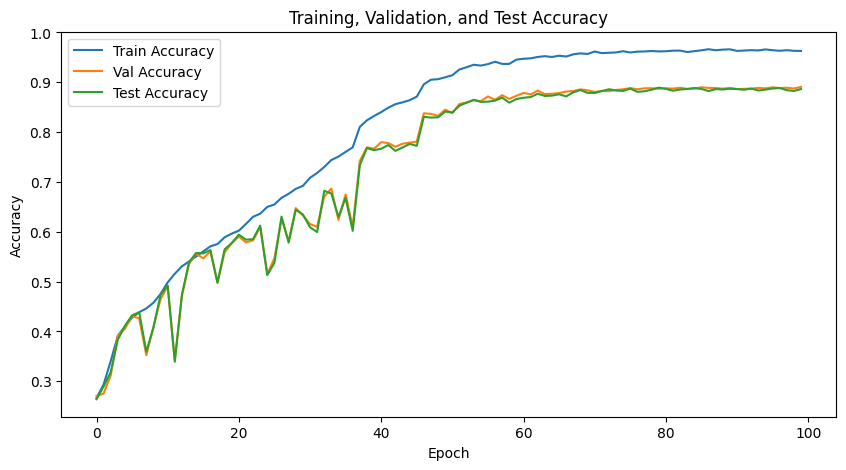

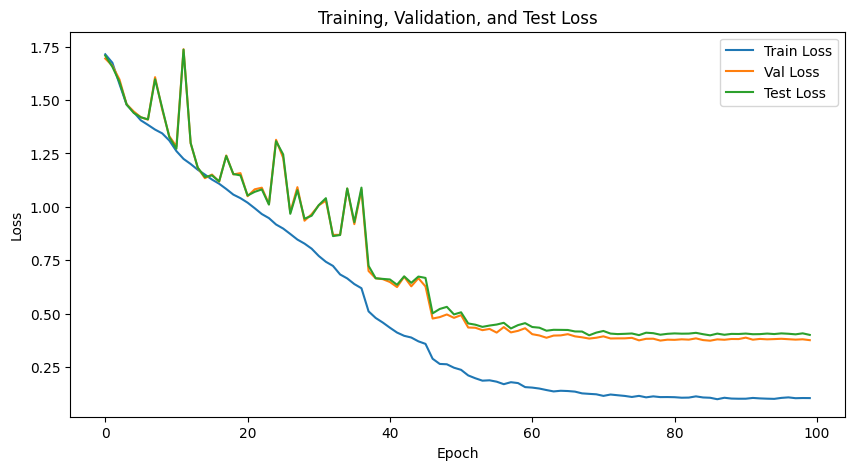

In [ ]:

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()
plt.show()

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()
plt.show()